# Autoencoder v3
Re-implemented v2 with enhancements

### Information
1. Eight-layer architecture (4 in encoder + 4 in decoder)
2. Dataset - 1000 STL files
3. Train - 800 models
4. Test - 200 models
5. Epochs - 50
6. Loss -  
    a. loss - 0.0180  
    b. val_loss - 0.0120

### Encoder architecture
- Conv3D(32, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')
- Conv3D(16, (3, 3, 3), activation='selu', padding='same')
- AveragePooling3D((2, 2, 2), padding='same')

### Changelog
#### First attempt
- Point cloud of 15k points
- SELU activation function instead of ELU which was used in v2
- AveragePooling3D instead of MaxPooling3D
- Loss reduced from 0.0214 to 0.0192
#### Second attempt
- Point cloud of 20k points
- Loss reduced from 0.0192 to 0.0180
- The same setup was run again, but with Leaky ReLU - loss increased to 0.0204, so it was decided to stick to SELU

### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, UpSampling3D, AveragePooling3D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-10-31 22:13:44.622334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 22:13:44.622381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 22:13:44.622432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 22:13:44.630283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hrishi/Miniconda3/envs/tensorflow/lib/python

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting STL to point cloud

**Execute the following cell if you wish to delete all existing point cloud files in abc-dataset-ply/ directory**

In [ ]:
folder_path = "abc-dataset-ply/"
files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")

**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [ ]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl/"))
for i in files:
    path = "abc-dataset-stl/" + i
    ConversionUtils.stl_to_ply(path, 20000)

### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply/"
# Taking first 1000 models
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path, 64)
    dataset.append(binvox)

In [3]:
print(len(dataset))

1000


### Splitting dataset for training and testing

In [4]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:800]  # Adjust the number as needed
test_dataset = dataset[800:]   # The remaining data for testing
print(len(train_dataset), len(test_dataset))
# Define the input shape
input_shape = (64, 64, 64, 1)

800 200


### Encoder

In [5]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(input_data)
x = AveragePooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(x)
encoded = AveragePooling3D((2, 2, 2), padding='same')(x)

2023-10-31 22:14:07.848975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 22:14:07.854867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 22:14:07.855305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Decoder

In [6]:
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Callbacks

#### Early Stopping

In [7]:
early_stopping = EarlyStopping(
    monitor="loss",
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

#### Checkpoint

In [8]:
checkpoint_filepath = 'checkpoints/v3/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

### Training autoencoder, prediction done on test dataset

In [9]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=50, batch_size=10, validation_data=(test_dataset, test_dataset), callbacks=[early_stopping, model_checkpoint_callback])

2023-10-31 22:14:48.282500: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-31 22:14:49.265151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-31 22:14:49.885953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.
2023-10-31 22:14:50.013820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 838860800 exceeds 10% of free system memory.


Epoch 1/50


2023-10-31 22:14:51.348976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-31 22:14:55.299562: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8ff5865050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 22:14:55.299593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-31 22:14:55.303272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 22:14:55.416874: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 30s 297ms/step - loss: 0.1256 - val_loss: 0.0499
Epoch 2/50
80/80 [==============================] - 23s 288ms/step - loss: 0.0531 - val_loss: 0.0393
Epoch 3/50
80/80 [==============================] - 23s 289ms/step - loss: 0.0459 - val_loss: 0.0353
Epoch 4/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0415 - val_loss: 0.0310
Epoch 5/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0380 - val_loss: 0.0274
Epoch 6/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0344 - val_loss: 0.0243
Epoch 7/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 8/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0301 - val_loss: 0.0221
Epoch 9/50
80/80 [==============================] - 23s 290ms/step - loss: 0.0292 - val_loss: 0.0203
Epoch 10/50
80/80 [==============================] - 23s 291ms/step - loss: 0.0281 - val_loss: 0.0198


In [37]:
reconstructed_data = autoencoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 2s 81ms/step


In [38]:
encoder = Model(inputs=input_data, outputs=encoded)
encoded_data = encoder.predict(test_dataset, batch_size=10)

20/20 [==============================] - 1s 24ms/step


#### Dimensions

In [39]:
print("Shape of input data: ", test_dataset[0].shape)
print("Shape of encoded data: ", encoded_data[0].shape)
print("Shape of reconstructed data: ", reconstructed_data[0].shape)

Shape of input data:  (64, 64, 64)
Shape of encoded data:  (16, 16, 16, 16)
Shape of reconstructed data:  (64, 64, 64, 1)


### Sample reconstruction from test dataset

In [40]:
import matplotlib.pyplot as plt

index = 20

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

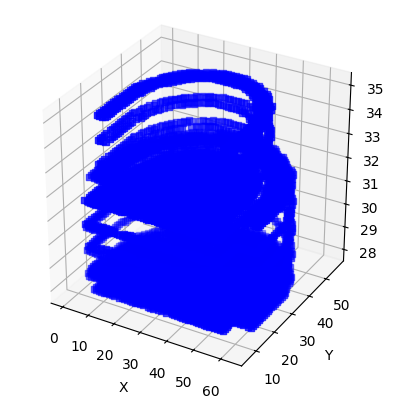

In [41]:
Visualization.matplotlib_visualize_original(original_sample)

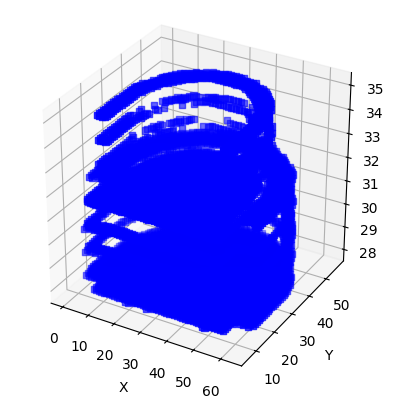

In [42]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [ ]:
path = "sample-outputs/v3/" + "original-" + str(index) + ".ply"
Visualization.open3d_visualize_original(original_sample, path)

In [ ]:
path = "sample-outputs/v3/" + "reconstructed-" + str(index) + ".ply"
Visualization.open3d_visualize_reconstructed(reconstructed_sample, path)